[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  1 of 1 completed


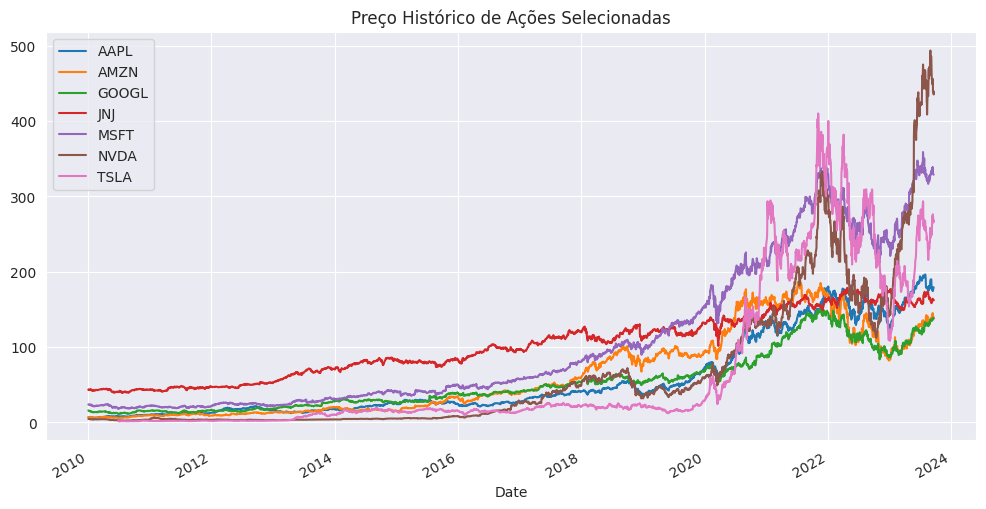

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

stocks = ['AAPL', 'AMZN','MSFT',  'GOOGL', 'NVDA', 'JNJ', 'TSLA']
start_date = '2010-01-01'
data = yf.download(stocks, start=start_date)['Adj Close']
benchmark = yf.download('^OEX', start=start_date)['Adj Close']

# Plotagem
sns.set_style('darkgrid')
data.plot(figsize=(12, 6))
plt.title('Preço Histórico de Ações Selecionadas')
plt.legend(loc='upper left')
plt.show()

In [7]:
import numpy as np

# Função Fitness
def fitness_function(weights, data):
    data_returns = np.log(data) - np.log(data.shift(1))
    data_returns = data_returns.dropna()

    portfolio_returns = np.dot(data_returns, weights)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
    return sharpe_ratio

In [8]:
# Algoritmo Genético
def genetic_algorithm(data, population_size=200, num_generations=50, mutation_rate=0.05, elitism=0.1):
    # Initialize the population
    population = np.random.rand(population_size, len(data.columns))
    population = population / np.sum(population, axis=1)[:, np.newaxis]

    # cálculo da população inicial
    fitness = np.array([fitness_function(individual, data) for individual in population])

    for generation in range(num_generations):
        # escolher pela função fitness
        sorted_idx = np.argsort(fitness)[::-1]
        population = population[sorted_idx]
        fitness = fitness[sorted_idx]

        # melhores
        num_elites = int(elitism * population_size)

        # melghores superados
        offspring = population[:num_elites]

        # seleção genética
        parent1_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent2_idx = np.random.randint(num_elites, population_size, size=population_size-num_elites)
        parent1 = population[parent1_idx]
        parent2 = population[parent2_idx]

        # próxima geração
        crossover_prob = np.random.rand(population_size-num_elites, len(data.columns))
        crossover_mask = crossover_prob <= 0.5
        offspring_crossover = np.where(crossover_mask, parent1, parent2)

        mutation_prob = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_mask = mutation_prob <= mutation_rate
        mutation_values = np.random.rand(population_size-num_elites, len(data.columns))
        mutation_direction = np.random.choice([-1, 1], size=(population_size-num_elites, len(data.columns)))
        offspring_mutation = np.where(mutation_mask, offspring_crossover + mutation_direction * mutation_values, offspring_crossover)

        # pesos válidos
        offspring_mutation = offspring_mutation / np.sum(offspring_mutation, axis=1)[:, np.newaxis]

        # combinar os melhores
        population = np.vstack((population[:num_elites], offspring_mutation))

        # Cálculo da geração posterior
        fitness = np.array([fitness_function(individual, data) for individual in population])

    # melhor peso para a carteira
    best_idx = np.argmax(fitness)
    best_individual = population[best_idx]
    print('Best Sharpe Ratio: ', np.max(fitness))

    return best_individual

Best Sharpe Ratio:  1.099161240313475


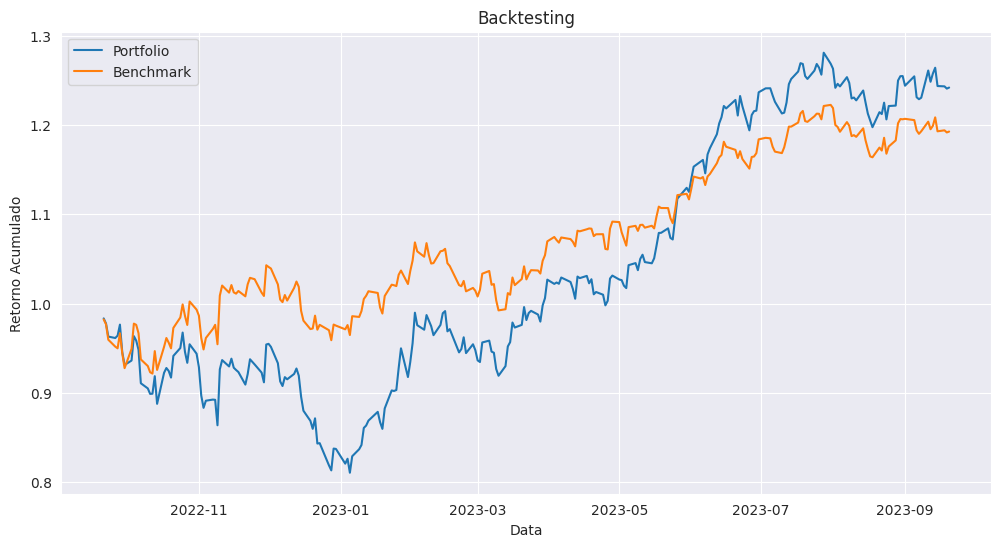

Estatísticas:
---------------------
Retorno Diário: 0.0010
Desvio Padrão: 0.0148
Sharpe: 1.0414
Valor Final: 1241.84

Benchmark:
---------------------
Retorno Diário: 0.0008
Desvio Padrãon: 0.0114
Sharpe: 1.0711
Valor Final: 1192.61


In [9]:

# algoritmo genético no backtesting
from datetime import datetime, timedelta

# reprodução
np.random.seed(42)

def backtest(genetic_algorithm, data, benchmark, initial_capital):
    # Splitar dados
    train_data = data.iloc[:-252]
    test_data = data.iloc[-252:]

    # melhores pesos para teste
    weights = genetic_algorithm(data=train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)
    # print(weights)

    # zerar pesos negativos
    weights[weights < 0] = 0

    # Normalizar pess para 1
    weights /= weights.sum()

    # cálcuo dos retornos
    portfolio_returns = np.dot(test_data.pct_change().dropna(), weights)
    portfolio_cum_returns = np.cumprod(1 + portfolio_returns)
    portfolio_value = initial_capital * portfolio_cum_returns[-1]
    benchmark_returns = benchmark.iloc[-252:].pct_change().dropna()
    benchmark_cum_returns = np.cumprod(1 + benchmark_returns)
    benchmark_value = initial_capital * benchmark_cum_returns[-1]

    # Cálculo das métricas de performance
    portfolio_mean_return = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    portfolio_sharpe_ratio = (portfolio_mean_return / portfolio_std) * np.sqrt(252)
    benchmark_mean_return = np.mean(benchmark_returns)
    benchmark_std = np.std(benchmark_returns)
    benchmark_sharpe_ratio = (benchmark_mean_return / benchmark_std) * np.sqrt(252)

    # print(portfolio_cum_returns)

    # Plotagem
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(benchmark_cum_returns.index, portfolio_cum_returns, label='Portfolio')
    ax.plot(benchmark_cum_returns, label='Benchmark')
    ax.set_xlabel('Data')
    ax.set_ylabel('Retorno Acumulado')
    ax.set_title('Backtesting')
    ax.legend()
    plt.show()

    # Print performance metrics
    print('Estatísticas:')
    print('---------------------')
    print('Retorno Diário: {:.4f}'.format(portfolio_mean_return))
    print('Desvio Padrão: {:.4f}'.format(portfolio_std))
    print('Sharpe: {:.4f}'.format(portfolio_sharpe_ratio))
    print('Valor Final: {:.2f}'.format(portfolio_value))
    print('')
    print('Benchmark:')
    print('---------------------')
    print('Retorno Diário: {:.4f}'.format(benchmark_mean_return))
    print('Desvio Padrãon: {:.4f}'.format(benchmark_std))
    print('Sharpe: {:.4f}'.format(benchmark_sharpe_ratio))
    print('Valor Final: {:.2f}'.format(benchmark_value))

    return portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns

portfolio_returns, benchmark_returns, portfolio_cum_returns, benchmark_cum_returns = backtest(genetic_algorithm, data, benchmark, initial_capital=1000)

Best Sharpe Ratio:  1.0937813609488327
Best Sharpe Ratio:  1.0553562702106232
Best Sharpe Ratio:  1.0466083650893458
Best Sharpe Ratio:  1.010966263215183
Best Sharpe Ratio:  1.0063790858562656
Best Sharpe Ratio:  1.0256593133512006
Best Sharpe Ratio:  1.036653805630266
Best Sharpe Ratio:  1.0429054469800636
Best Sharpe Ratio:  1.0622966072710902
Best Sharpe Ratio:  1.0960184041534182
Best Sharpe Ratio:  1.113288586355361


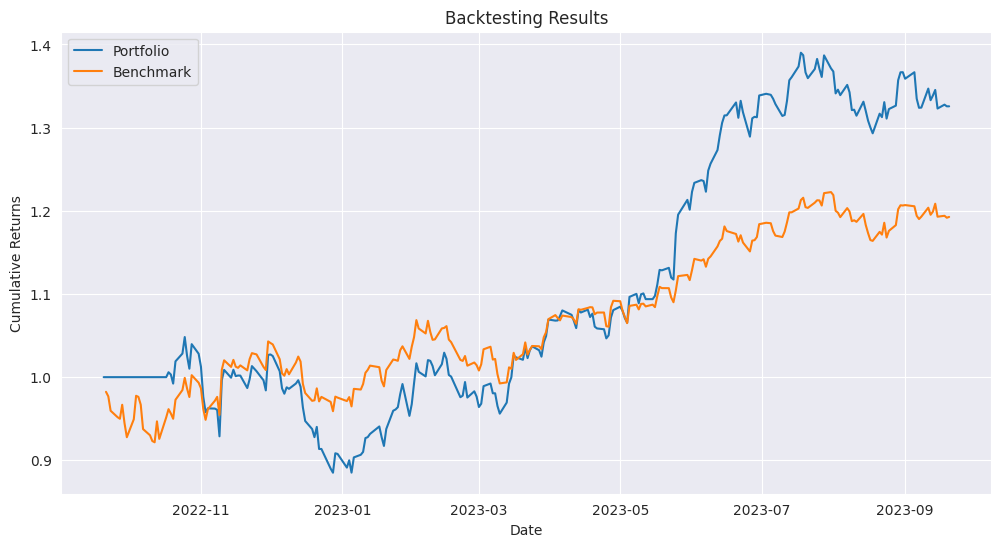

Portfolio Statistics:
---------------------
Mean Daily Return: 0.12%
Standard Deviation: 4.76%
Sharpe Ratio: -0.29
Final Value: 1325.57

Benchmark Statistics:
---------------------
Mean Daily Return: 0.08%
Standard Deviation: 3.94%
Sharpe Ratio: -0.36
Final Value: 1192.61



In [10]:
# Seed for reproducibility
np.random.seed(42)

def backtest_monthly(optimization_function, data, benchmark, initial_capital):

    # Initialize the portfolio value and the portfolio weights
    # initial_capital = 1000
    portfolio_value = initial_capital
    test_data = data.iloc[-252:]

    # Initialize history of weights and portfolio values
    weights_history = pd.DataFrame(index=test_data.index, columns=data.columns)
    portfolio_value_history = pd.Series(index=test_data.index, name='Portfolio Value', dtype='float')
    portfolio_value_history.iloc[0] = portfolio_value

    # Loop through the data one month at a time
    for i in range(21, len(test_data), 21):
        # Get the data for the current month
        month_data = test_data.iloc[i-21:i]

        # Call the optimization function to get the portfolio weights for the current month
        train_data = data.loc[:month_data.index[0]]
        weights = optimization_function(train_data, population_size=100, num_generations=50, mutation_rate=0.01, elitism=0.01)

        # Set any negative weights to 0
        weights[weights < 0] = 0

        # Normalize remaining positive weights to sum to 1
        weights /= weights.sum()

        # Save the weights for the current month
        weights_history.loc[month_data.index[-1]] = weights
        month_returns = month_data.pct_change() * weights

        # Loop through the data one day at a time
        for j in range(1, len(month_returns)):
            # Calculate the portfolio value for the current day
            day_returns = month_returns.iloc[j]
            portfolio_value = (1 + day_returns.sum()) * portfolio_value

            # Update the portfolio value and save it to the history
            portfolio_value_history.loc[month_returns.index[j]] = portfolio_value

    # Calculate the portfolio returns and the benchmark returns
    weights_history = weights_history.fillna(method='ffill')
    portfolio_returns = (weights_history[:-1] * test_data.pct_change()[1:]).sum(axis=1)
    benchmark_returns = benchmark.iloc[-252:].pct_change()[1:]


    # Calculate the statistics
    portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()
    portfolio_mean_return = portfolio_returns.mean()
    benchmark_mean_return = benchmark_returns.mean()
    portfolio_volatility = portfolio_returns.std() * np.sqrt(12)
    benchmark_volatility = benchmark_returns.std() * np.sqrt(12)
    sharpe_ratio = (portfolio_mean_return - 0.015) / portfolio_volatility
    benchmark_sharpe_ratio = (benchmark_mean_return - 0.015) / benchmark_volatility

    # Portfolio & Benchmark value
    benchmark_value = initial_capital * benchmark_cumulative_returns[-1]
    portfolio_value = initial_capital * portfolio_cumulative_returns[-1]


    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_cumulative_returns, label='Portfolio')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    plt.legend(loc='upper left')
    plt.title('Backtesting Results')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.show()

    # Print the portfolio statistics
    print('Portfolio Statistics:')
    print('---------------------')
    print(f'Mean Daily Return: {portfolio_mean_return:.2%}')
    print(f'Standard Deviation: {portfolio_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print('Final Value: {:.2f}'.format(portfolio_value))
    print()

    # Print the benchmark statistics
    print('Benchmark Statistics:')
    print('---------------------')
    print(f'Mean Daily Return: {benchmark_mean_return:.2%}')
    print(f'Standard Deviation: {benchmark_volatility:.2%}')
    print(f'Sharpe Ratio: {benchmark_sharpe_ratio:.2f}')
    print('Final Value: {:.2f}'.format(benchmark_value))
    print()


    return weights_history, portfolio_value_history, portfolio_cumulative_returns, benchmark_cumulative_returns

# Run backtesting
weights_history, portfolio_value_history, portfolio_cumulative_returns, benchmark_cumulative_returns = backtest_monthly(genetic_algorithm, data, benchmark, initial_capital=1000)